In [170]:
import quantsight as qs

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

api_key = "Add your api key"
qs = qs.Quantsight(api_key=api_key)

In [171]:
# download daily candles from OKX
candles = qs.get_ohlcv(
    period="1d",
    exchange="okx",
    limit=1e6,
)
candles = candles.drop_duplicates(subset=['ticker', 'ts'])

We can conlude from the plot below, that all else being equal on average we are better off executing on weekdays thanks to higher liquidity. If we could pick a day, Thursday is good option given smallest variance and highest median/mean.

> Idea for next step; Calculate the same plot for each time zone (Europe, US, Asia)

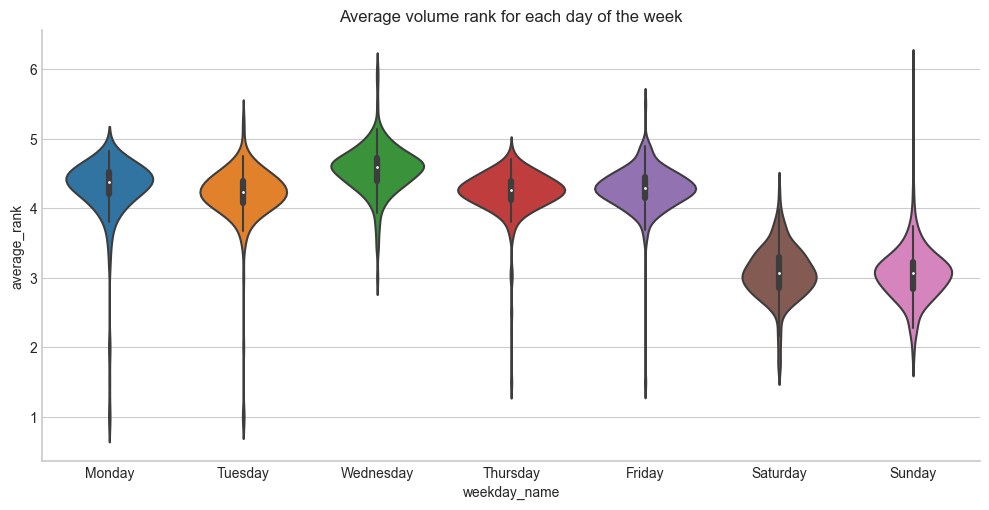

In [173]:
# do seasonality analysis on volume
candles['day_of_week'] = candles["ts"].dt.isocalendar().day
candles['week_no'] = candles["ts"].dt.isocalendar().week
candles['year'] = candles["ts"].dt.isocalendar().year
WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

output_df = pd.DataFrame()

# this ways seems long-winded but allows us to compute the agreegate with seaborn and display the variace
for ticker, ticker_df in candles.groupby("ticker"):
    ticker_df["rank"] = ticker_df.groupby(["week_no", "year"])['volume'].rank()
    agg_by_week = ticker_df.groupby("day_of_week")['rank'].mean()
    series = agg_by_week.reset_index()['rank'].rename(ticker)
    output_df  = pd.concat([output_df, series], axis=1)
    if ticker_df['rank'].max() > 7:
        print("hey")
        break

tickers  = output_df.columns
output_df['weekday_name'] = WEEKDAYS

# convert to long for compatibility with seaborn
long_format = pd.melt(output_df, id_vars='weekday_name', value_vars=tickers, value_name="average_rank")

g = sns.catplot(
    data=long_format,
    x='weekday_name',
    y='average_rank',
    kind="violin",
    height=5,
    aspect=2
).set(title="Average volume rank for each day of the week")